In [23]:
# import the libraries as shown below
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from keras.applications.mobilenet_v2 import MobileNetV2
#from tensorflow.keras.applications.MobileNet import MobileNet
#from keras.applications.MobileNet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [24]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"dataset1\train",
    seed=123,
    shuffle=True,
    image_size=(224,224),
    batch_size=32
)

Found 1351 files belonging to 4 classes.


In [25]:
class_names = dataset.class_names
class_names

['Degree1', 'Degree2', 'Degree3', 'healthy']

In [26]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[1 1 0 0 1 1 3 1 2 3 0 0 0 1 0 1 1 3 0 0 1 0 0 0 3 3 0 2 0 3 3 0]


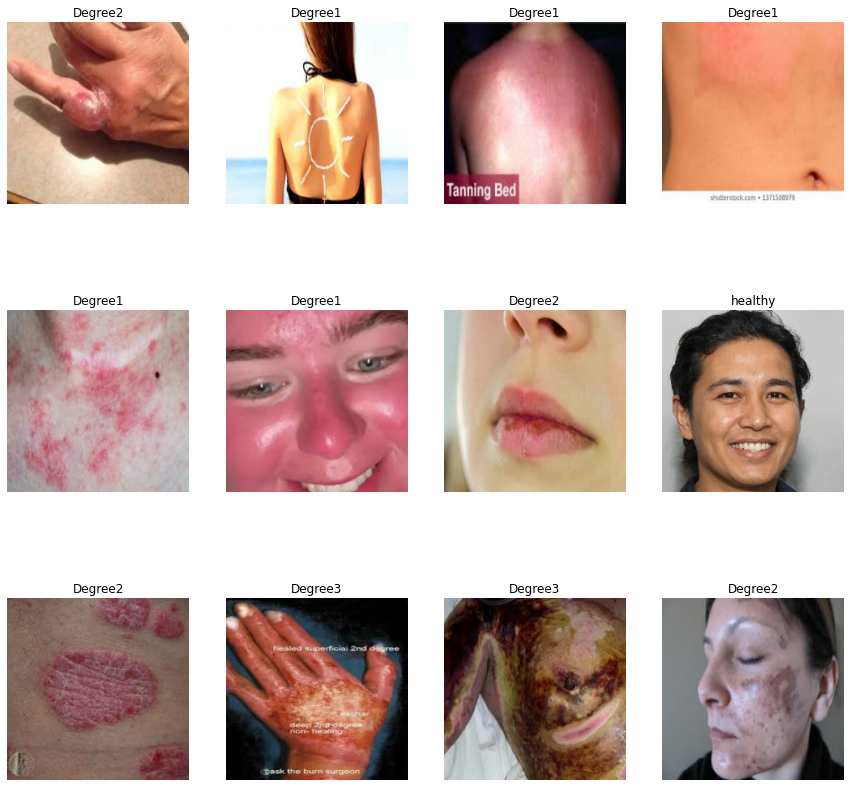

In [27]:
plt.figure(figsize=(15, 15
                   ))
for image_batch, labels_batch in dataset.take(5):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [28]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

In [29]:
train_path =  r"dataset1\train"
valid_path =   r"dataset1\val"

In [30]:
# add preprocessing layer to the front of VGG
mobilnet = MobileNetV2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [31]:
# don't train existing weights
for layer in mobilnet.layers:
    layer.trainable = False

In [32]:
# our layers - you can add more if you want
x = Flatten()(mobilnet.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(4, activation='softmax')(x)

In [33]:
# create a model object
model = Model(inputs=mobilnet.input, outputs=prediction)

In [34]:
# view the structure of the model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [35]:
# tell the model what cost and optimization method to use
model.compile(
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  optimizer='adam',
  metrics=['accuracy']
    
)

In [36]:
from keras.preprocessing.image import ImageDataGenerator

training_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.3,
                                   zoom_range = 0.2,
                                   rotation_range=10,
                                   horizontal_flip = True)

training_generator = training_datagen.flow_from_directory(  r"dataset1\train",
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')



Found 1351 images belonging to 4 classes.


In [37]:
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range = 0.3,
        zoom_range = 0.2,
        rotation_range=10,
        horizontal_flip=True)

validation_generator = validation_datagen.flow_from_directory(
        r'dataset1/val',
        target_size=(224,224),
        batch_size=32,
        class_mode="sparse"
)

Found 168 images belonging to 4 classes.


In [38]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory( r"dataset1\test",
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')


Found 171 images belonging to 4 classes.


In [39]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit(
  training_generator,
  validation_data=validation_generator,
  epochs=25,
  steps_per_epoch=len(training_generator),
  validation_steps=len(validation_generator)
)

Epoch 1/25
43/43 [==============================] - 35s 773ms/step - loss: 3.8665 - accuracy: 0.6965 - val_loss: 1.8874 - val_accuracy: 0.7738
Epoch 2/25
43/43 [==============================] - 32s 742ms/step - loss: 1.6453 - accuracy: 0.8283 - val_loss: 3.5573 - val_accuracy: 0.7381
Epoch 3/25
43/43 [==============================] - 32s 743ms/step - loss: 1.2180 - accuracy: 0.8571 - val_loss: 2.8251 - val_accuracy: 0.7560
Epoch 4/25
43/43 [==============================] - 32s 736ms/step - loss: 0.9200 - accuracy: 0.8912 - val_loss: 2.0445 - val_accuracy: 0.8155
Epoch 5/25
43/43 [==============================] - 32s 735ms/step - loss: 0.8537 - accuracy: 0.8838 - val_loss: 2.1198 - val_accuracy: 0.8274
Epoch 6/25
43/43 [==============================] - 32s 742ms/step - loss: 0.8905 - accuracy: 0.9141 - val_loss: 3.6770 - val_accuracy: 0.7798
Epoch 7/25
43/43 [==============================] - 32s 749ms/step - loss: 1.3146 - accuracy: 0.8756 - val_loss: 2.8844 - val_accuracy: 0.7976

In [40]:
scores = model.evaluate(test_set)

6/6 [==============================] - 3s 452ms/step - loss: 6.0771 - accuracy: 0.7836


In [41]:
acc = r.history['accuracy']
val_acc = r.history['val_accuracy']

loss = r.history['loss']
val_loss = r.history['val_loss']

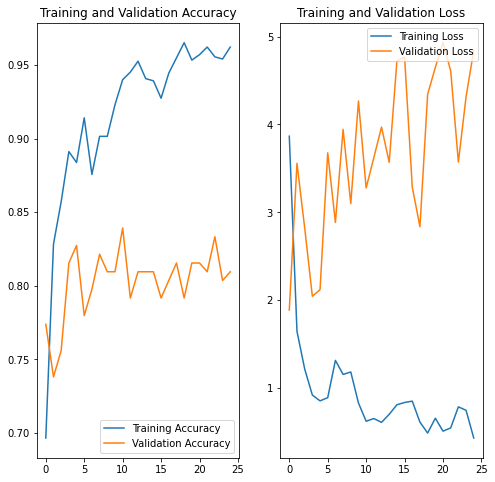

In [42]:
EPOCHS = 25

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [43]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 30ms/step


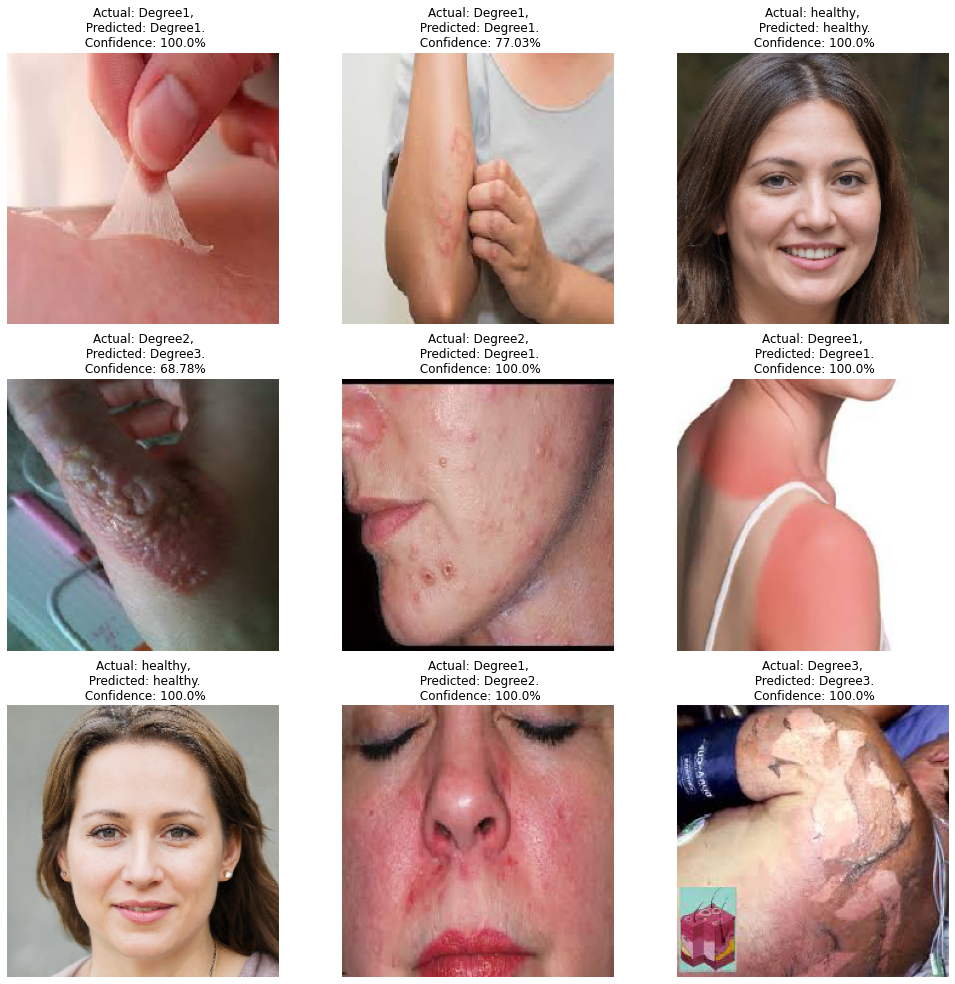

In [46]:
plt.figure(figsize=(17, 17))
for images, labels in test_set:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break